In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Rescaling
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


pd.set_option('display.precision', 3)

# Advanced deep learning techniques with keras

## Setup

### Load data: MNIST digits

In [5]:
# Load data with predefined train/test split
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Decrease the size of train set for quicker computations
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size=10000, random_state=20250324, stratify=y_train_full)

# Feature engineering
num_classes = 10
y_sets = [y_train, y_test, y_val]
y_train, y_test, y_val = [to_categorical(y, num_classes=num_classes) for y in y_sets]

x_sets = [X_train, X_test, X_val]
X_train, X_test, X_val = [Rescaling(1./255)(x) for x in x_sets]

### Helper functions

In [6]:
def plot_history(fit_history, metric="accuracy"):
    plt.plot(fit_history[metric], label='Training')
    plt.plot(fit_history[f'val_{metric}'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'{metric} history on training and validation sets')
    plt.legend()
    plt.show()

In [8]:
class ResultCollector:
    def __init__(self):
        self.results = {}
        
    def add_model(self, name, train_acc, test_acc):
        """Add or update a model's results."""
        self.results[name] = {
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc
        }
        return self.get_table()
    
    def get_table(self):
        """Get the results table with optional styling."""
        df = pd.DataFrame(self.results).T
        return df.style.format("{:.3f}").background_gradient(cmap='RdYlGn', axis=None)
    
results = ResultCollector()

## Convolution with keras

Convolutional layers are designed to operate on images or time-series data with multiple sensors, so they expect input data to have a channel dimension. In our case, since we are dealing with grayscale images, we will have only one channel (unlike the RGB channels in color images). To ensure our data has this channel dimension, we need to reshape our data first. Let's collect all the preprocessing steps, and create new preprocessed sets.

In [9]:
from keras.layers import Reshape

preprocess = Sequential([
    Input(shape=X_train.shape[1:]),
    Reshape(target_shape=(X_train.shape[1], X_train.shape[2], 1))  # explicitly state the 4th (channel) dimension
])

In [10]:
X_train.shape

TensorShape([10000, 28, 28])

In [11]:
preprocess(X_train).shape

TensorShape([10000, 28, 28, 1])

*Question*: Why are there no `compile()` and `fit()` steps?

<details>
<summary>Answer</summary>

This model only contains deterministic transformations with no trainable parameters. Thus, we don't need an optimizer, loss function, or metrics. We can just call it directly on our data as a function to transform inputs.

</details>

</br>



In [12]:
from keras.layers import Conv2D, MaxPooling2D

cnn_layers = Sequential([
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Create the model
model_cnn = Sequential([
    preprocess,
    cnn_layers
])

# Compile the model
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_cnn.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 10)             │        34,826 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
print(cnn_layers.summary())
# 32*(3*3+1)
# 64*(32*3*3+1) -- bias term is not channel-specific as it does not depend on the input data
# (64*5*5)*10+10

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
# Fit the model
history_cnn = model_cnn.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=512,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)]
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.2959 - loss: 2.1259 - val_accuracy: 0.7952 - val_loss: 1.1440
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7160 - loss: 0.9882 - val_accuracy: 0.8797 - val_loss: 0.4218
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.8408 - loss: 0.4972 - val_accuracy: 0.9175 - val_loss: 0.2932
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.8977 - loss: 0.3426 - val_accuracy: 0.9343 - val_loss: 0.2304
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9213 - loss: 0.2567 - val_accuracy: 0.9430 - val_loss: 0.1954
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9347 - loss: 0.2235 - val_accuracy: 0.9485 - val_loss: 0.1722
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9365 - loss: 0.2064 - val_accuracy: 0.9568 - val_loss: 0.1494
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9497 - loss: 0.1641 - val_accuracy: 0.

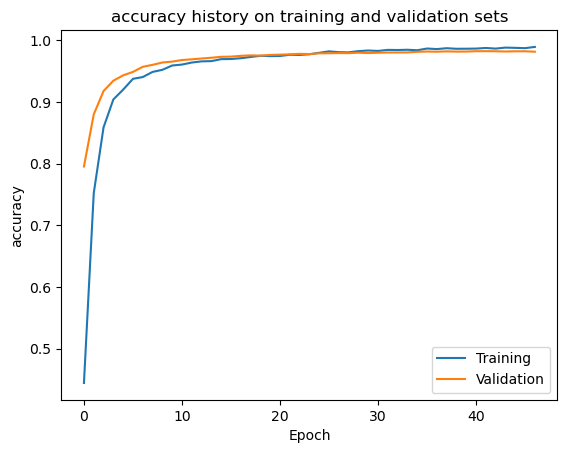

In [15]:
plot_history(history_cnn.history)

In [29]:
train_loss, train_accuracy = model_cnn.evaluate(X_train, y_train)
test_loss, test_accuracy = model_cnn.evaluate(X_val, y_val)
results.add_model("Convolutional Neural Network", train_accuracy, test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9955 - loss: 0.0163
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9833 - loss: 0.0565


,Train Accuracy,Test Accuracy
Keras MLP (CNN),0.996,0.981
Convolutional Neural Network,0.996,0.984


## Other useful tricks: data augmentation

We can exploit the fact that slight modifications of the images preserve the relevant nature of the images while changing all the pixels. This way, we could create new data from the existing samples.

Below, we create a new sequential operation applying two such transformations on the digits: rotation and zoom. The first parameters specifies the maximum amount of transformation, the second one how to fill values for the newly created pixels (here: fill with the value of the nearest pixels).

Data augmentation layers in Keras like `RandomRotation` and `RandomZoom` are designed to work with batches of images, not individual images.

In [17]:
from keras.layers import RandomRotation, RandomZoom

data_augmentation = Sequential([
    RandomRotation(0.05, fill_mode="nearest"),  # randomly rotate the pics any direction by 10% the most
    RandomZoom(0.05, fill_mode="nearest")  # zoom in/out by 10% the most
])

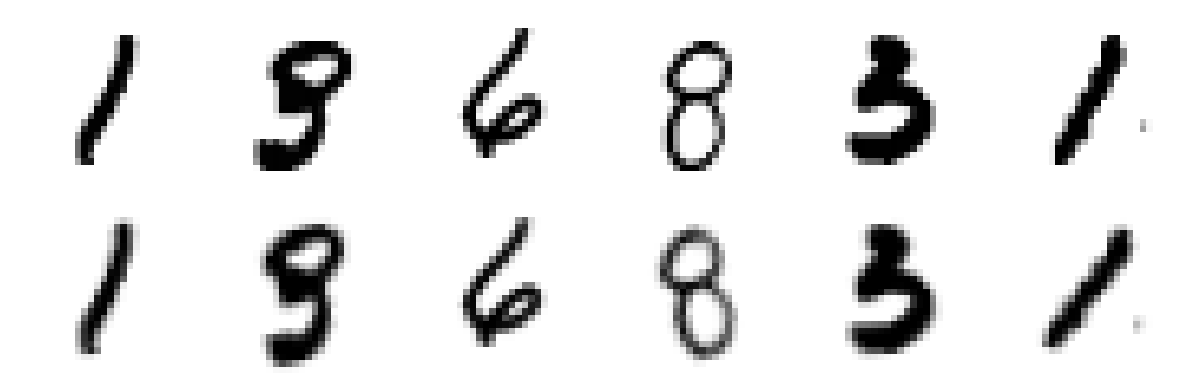

In [18]:
# Get a batch of sample images
number_of_digits_to_show = 6
sample_images = X_train[:number_of_digits_to_show]

# Preprocess and augment them all at once
preprocessed_images = preprocess(sample_images)
augmented_images = data_augmentation(preprocessed_images)


# Look at the transformations
fig, axs = plt.subplots(2, number_of_digits_to_show, figsize=(2*number_of_digits_to_show, 4))


for i in range(number_of_digits_to_show):
    # Display preprocessed images (top row)
    axs[0, i].imshow(preprocessed_images[i], cmap="binary")
    axs[0, i].axis("off")
    
    # Display augmented images (bottom row)
    axs[1, i].imshow(augmented_images[i], cmap="binary")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

In [19]:
model_cnn_da = Sequential([
    preprocess,
    data_augmentation,
    cnn_layers
])

print(model_cnn_da.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 10)             │        34,826 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
# Compile the model
model_cnn_da.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn_da = model_cnn_da.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)] # increase patience for slower learning
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9805 - loss: 0.0625 - val_accuracy: 0.9841 - val_loss: 0.0547
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9788 - loss: 0.0653 - val_accuracy: 0.9838 - val_loss: 0.0560
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9782 - loss: 0.0668 - val_accuracy: 0.9847 - val_loss: 0.0548
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9795 - loss: 0.0607 - val_accuracy: 0.9843 - val_loss: 0.0557
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9798 - loss: 0.0599 - val_accuracy: 0.9842 - val_loss: 0.0550
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9802 - loss: 0.0622 - val_accuracy: 0.9850 - val_loss: 0.0538
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9794 - loss: 0.0624 - val_accuracy: 0.9847 - val_loss: 0.0535
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9820 - loss: 0.0626 - val_accuracy: 0.

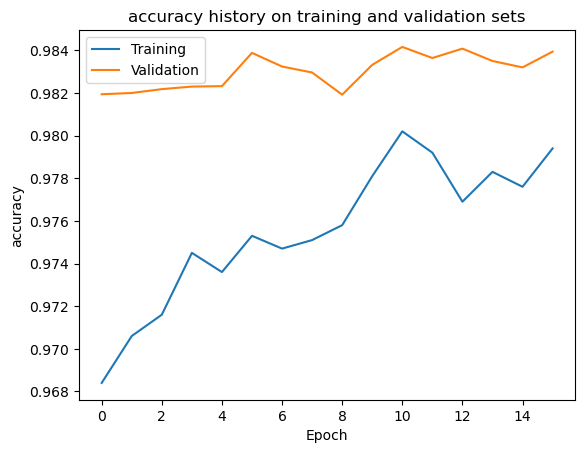

In [21]:
plot_history(history_cnn_da.history)

In [ ]:
train_loss, train_accuracy = model_cnn_da.evaluate(X_train, y_train)
test_loss, test_accuracy = model_cnn_da.evaluate(X_val, y_val)
results.add_model("CNN with Data augmentation", train_accuracy, test_accuracy)

## Unsupervised learning with neural networks: Auto-encoder

In [23]:
encoding_dimension = 154  # to compare with PCA of the previous class

encoder_layers = Sequential([
    Input(shape=X_train.shape[1:]),
    Flatten(),
    Dense(encoding_dimension, activation='relu')
])

decoder_layers = Sequential([
    Input(shape=(encoding_dimension,)),
    Dense(X_train.shape[1] * X_train.shape[2], activation='relu'),
    Reshape(target_shape=X_train.shape[1:])
])

autoencoder_model = Sequential([
    encoder_layers,
    decoder_layers
])

autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy')  # we can think of the rescaled pixels as probabilities of being black

# we can summarize our model.
autoencoder_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 154)            │       120,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 28, 28)         │       121,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,410 (946.91 KB)

 Trainable params: 242,410 (946.91 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train the autoencoder
history_autoencoder = autoencoder_model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2188 - val_loss: 0.2110
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2043 - val_loss: 0.2053
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2147 - val_loss: 0.2716
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2694 - val_loss: 0.2849
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3018 - val_loss: 0.2559
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2432 - val_loss: 0.2357
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2265 - val_loss: 0.2304
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2290 - val_loss: 0.2095
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2106 - val_loss: 0.2029
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2009 - val_loss: 0.1946
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2068 - val_loss: 0.2207
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2267 - val_lo

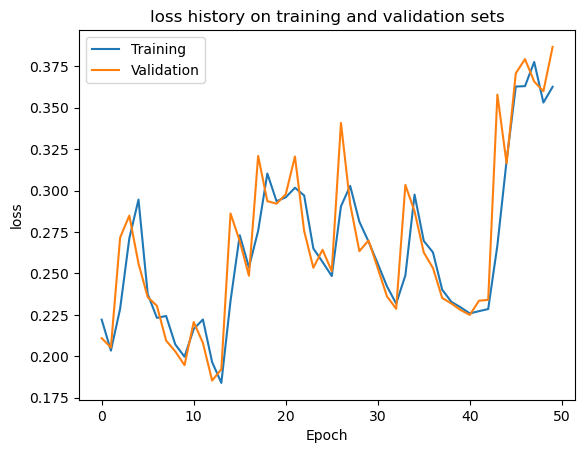

In [33]:
plot_history(history_autoencoder.history, metric="loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


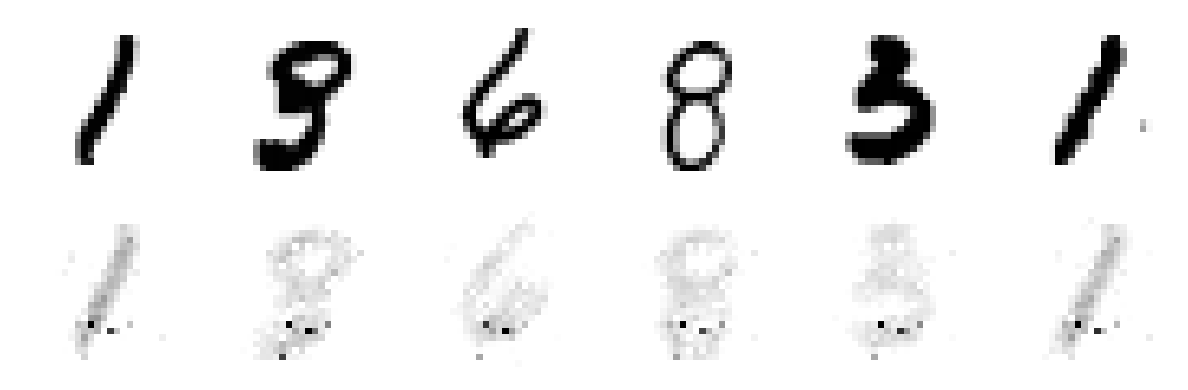

In [34]:
# Get a batch of sample images
number_of_digits_to_show = 6
sample_images = X_train[:number_of_digits_to_show]

reconstructed_img = autoencoder_model.predict(sample_images)


# Look at the transformations
fig, axs = plt.subplots(2, number_of_digits_to_show, figsize=(2*number_of_digits_to_show, 4))

for i in range(number_of_digits_to_show):
    # Display preprocessed images (top row)
    axs[0, i].imshow(sample_images[i], cmap="binary")
    axs[0, i].axis("off")
    
    # Display augmented images (bottom row)
    axs[1, i].imshow(reconstructed_img[i], cmap="binary")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

#### Create a new model with more aggressive compression

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 28, 28)         │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9016 - val_loss: 0.3338
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3186 - val_loss: 0.3019
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2955 - val_loss: 0.2872
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2823 - val_loss: 0.2733
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2693 - val_loss: 0.2614
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2571 - val_loss: 0.2522
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2481 - val_loss: 0.2417
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2413 - val_loss: 0.2405
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2424 - val_loss: 0.2436
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2355 - val_loss: 0.2237
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2222 - val_loss: 0.2202
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2187 - val_lo

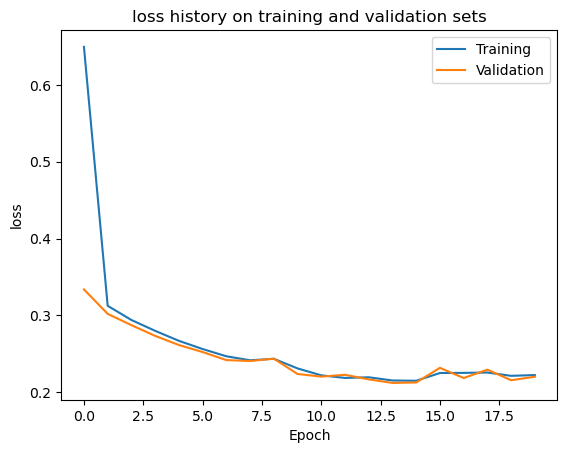

In [27]:
encoding_dimension = 32  # to compare with PCA of the previous class

encoder_layers = Sequential([
    Input(shape=X_train.shape[1:]),
    Flatten(),
    Dense(encoding_dimension, activation='relu')
])

decoder_layers = Sequential([
    Input(shape=(encoding_dimension,)),
    Dense(X_train.shape[1] * X_train.shape[2], activation='relu'),
    Reshape(target_shape=X_train.shape[1:])
])

autoencoder_model_32 = Sequential([
    encoder_layers,
    decoder_layers
])

autoencoder_model_32.compile(optimizer='adam', loss='binary_crossentropy')  # we can think of the rescaled pixels as probabilities of being black

# we can summarize our model.
autoencoder_model_32.summary()

history_autoencoder_32 = autoencoder_model_32.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

plot_history(history_autoencoder_32.history, metric="loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


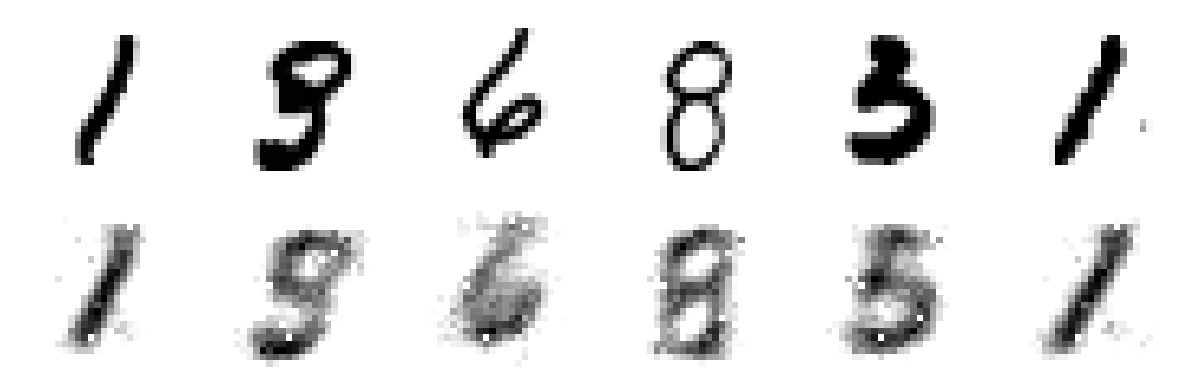

In [31]:
number_of_digits_to_show = 6
sample_images = X_train[:number_of_digits_to_show]

reconstructed_img = autoencoder_model_32.predict(sample_images)


# Look at the transformations
fig, axs = plt.subplots(2, number_of_digits_to_show, figsize=(2*number_of_digits_to_show, 4))

for i in range(number_of_digits_to_show):
    # Display preprocessed images (top row)
    axs[0, i].imshow(sample_images[i], cmap="binary")
    axs[0, i].axis("off")
    
    # Display augmented images (bottom row)
    axs[1, i].imshow(reconstructed_img[i], cmap="binary")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

This demonstrates the *"bottleneck principle"* in autoencoders: A properly sized bottleneck forces the model to learn efficient representations.

- Too narrow: loses important information (underfitting)
- Too wide: captures noise (overfitting)

How come that reconstruction error decreases while quality decreases?

- The model is optimizing for pixel-wise similarity (like MSE or binary cross-entropy)
- These metrics don't distinguish between meaningful structure and noise
- The model has no way to know which variations are "noise" vs "signal"


Autoencoders compress input into a latent space that captures important features. This could come handy when we have a few labeled examples but many unlabeled ones (typical real-world scenario). We can use all the unlabeled examples to learn a few important dimension ("feature-extraction) and use those limited number of features for the supervised learning task (this is called semi-supervised learning). Modern LLMs apply the same philosophy when learning contextual representations of text.

### Visualize the latent space

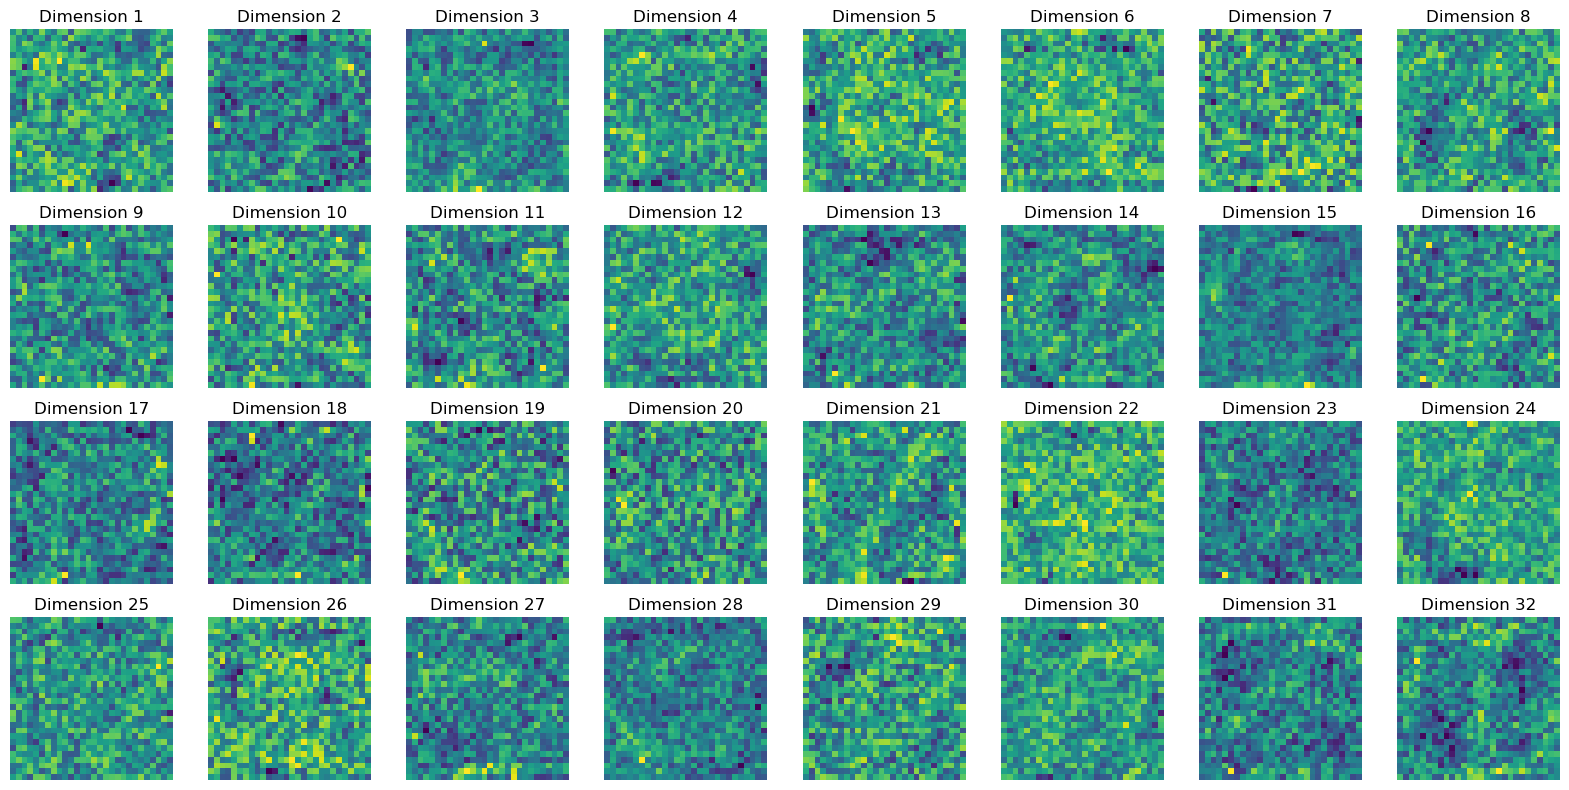

In [45]:
# Visualize the weights of the encoder layers

# Reshape the weights to 28x28 for each of the 32 dimensions
weights = encoder_layers.weights[0].numpy().reshape((28, 28, 32))

plt.figure(figsize=(16, 8))

# Plot each of the 32 weight grids
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(weights[:, :, i], cmap='viridis')
    plt.title(f'Dimension {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step


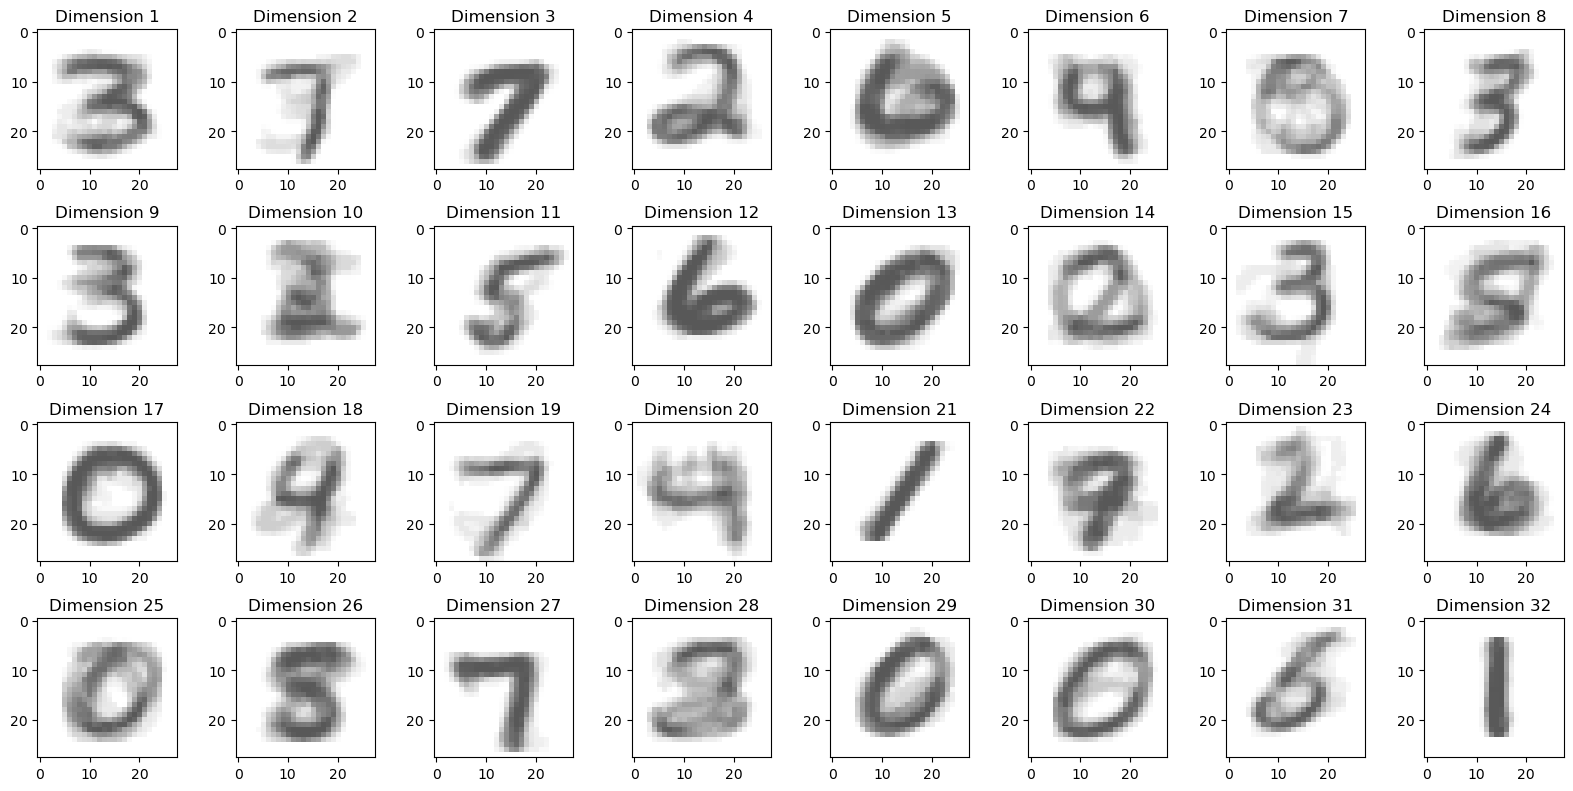

In [70]:
# Choose the top 10 images that maximally activate each dimension
encoder_predictions = encoder_layers.predict(X_test)
top_indices = np.argsort(encoder_predictions, axis=0)[-10:]

plt.figure(figsize=(16, 8))
for i in range(encoding_dimension):
    
    # Create a subplot for this dimension
    plt.subplot(4, 8, i+1)
    plt.title(f'Dimension {i+1}')
    
    # Display a stack of the top activating images
    for j in top_indices[:,i]:
        # Add the image with some offset for visualization
        plt.imshow(X_test[j], cmap='binary', alpha=0.1)
            
plt.tight_layout()

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3820 - val_loss: 0.1902
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1801 - val_loss: 0.1531
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1496 - val_loss: 0.1336
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1313 - val_loss: 0.1212
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1202 - val_loss: 0.1127
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1127 - val_loss: 0.1071
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1075 - val_loss: 0.1029
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1033 - val_loss: 0.0997
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1002 - val_loss: 0.0972
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0980 - val_loss: 0.0954
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


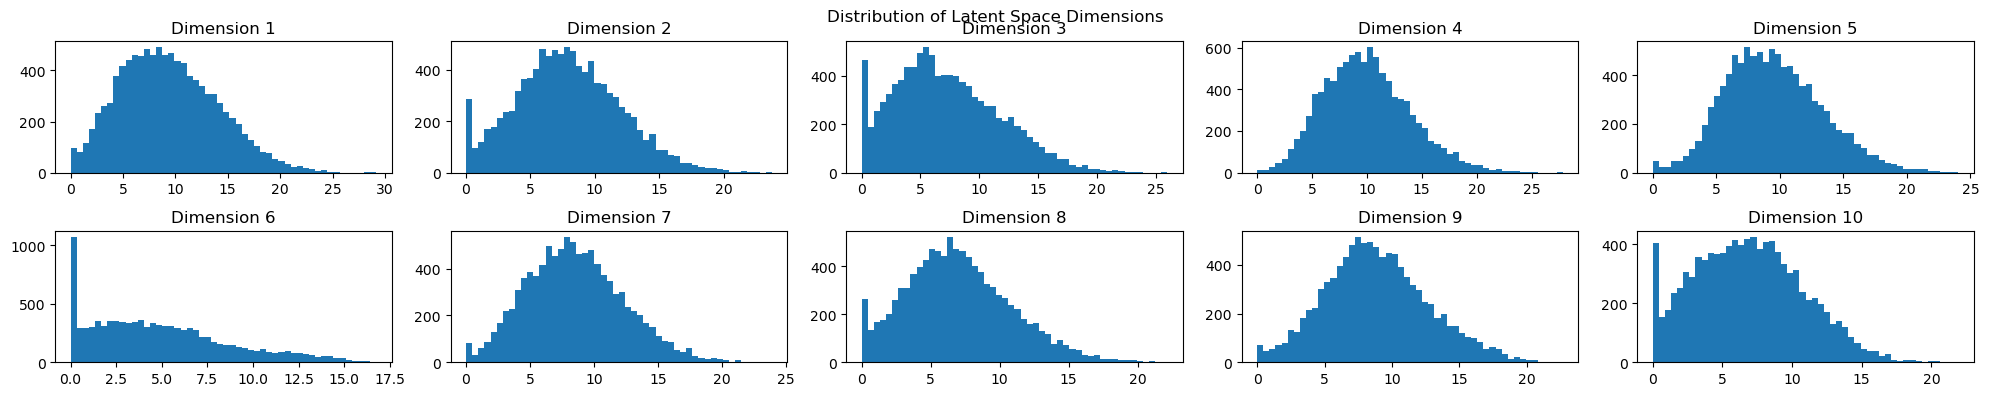

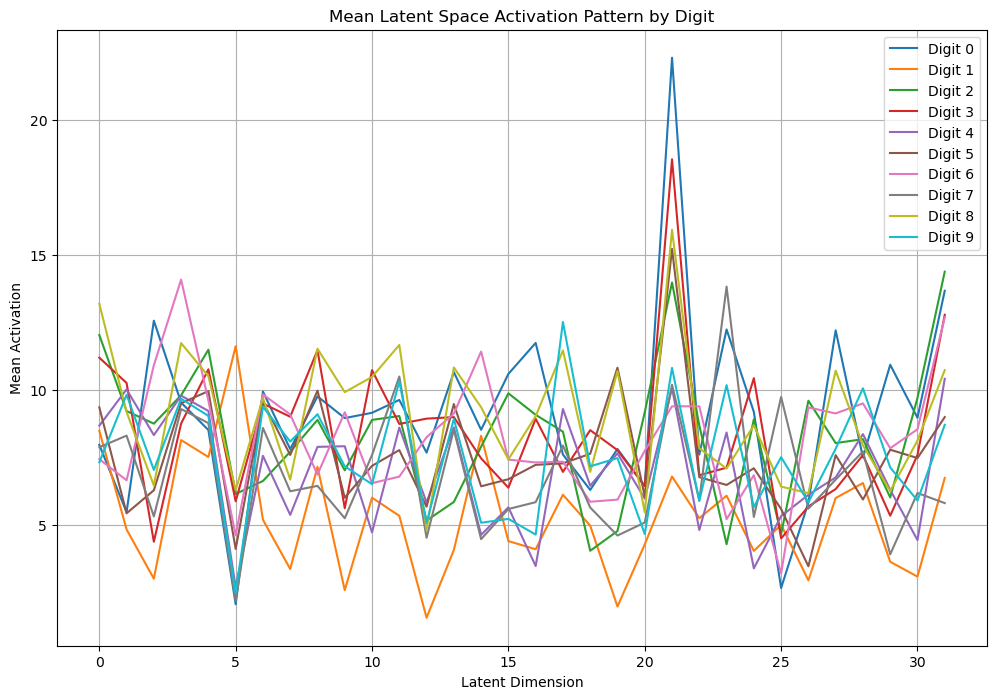

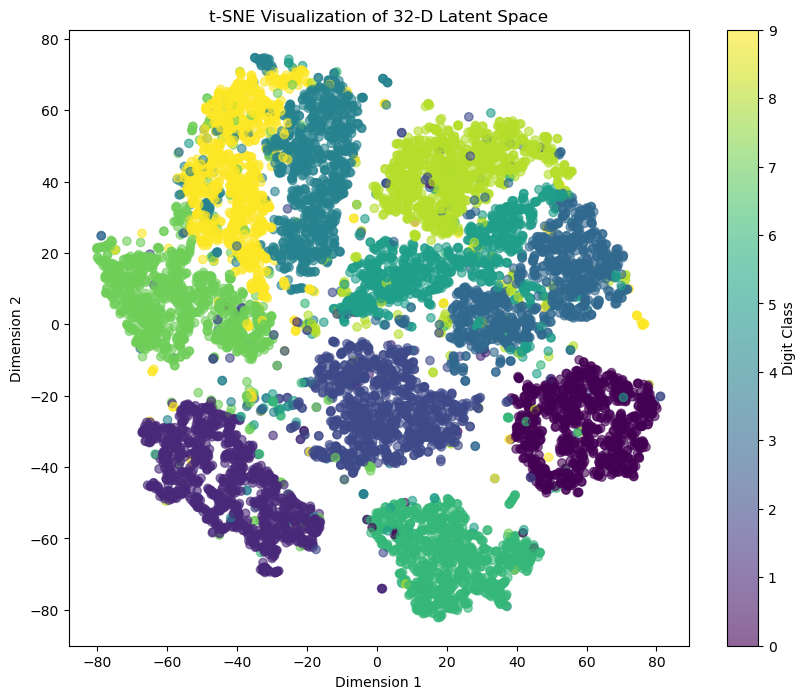

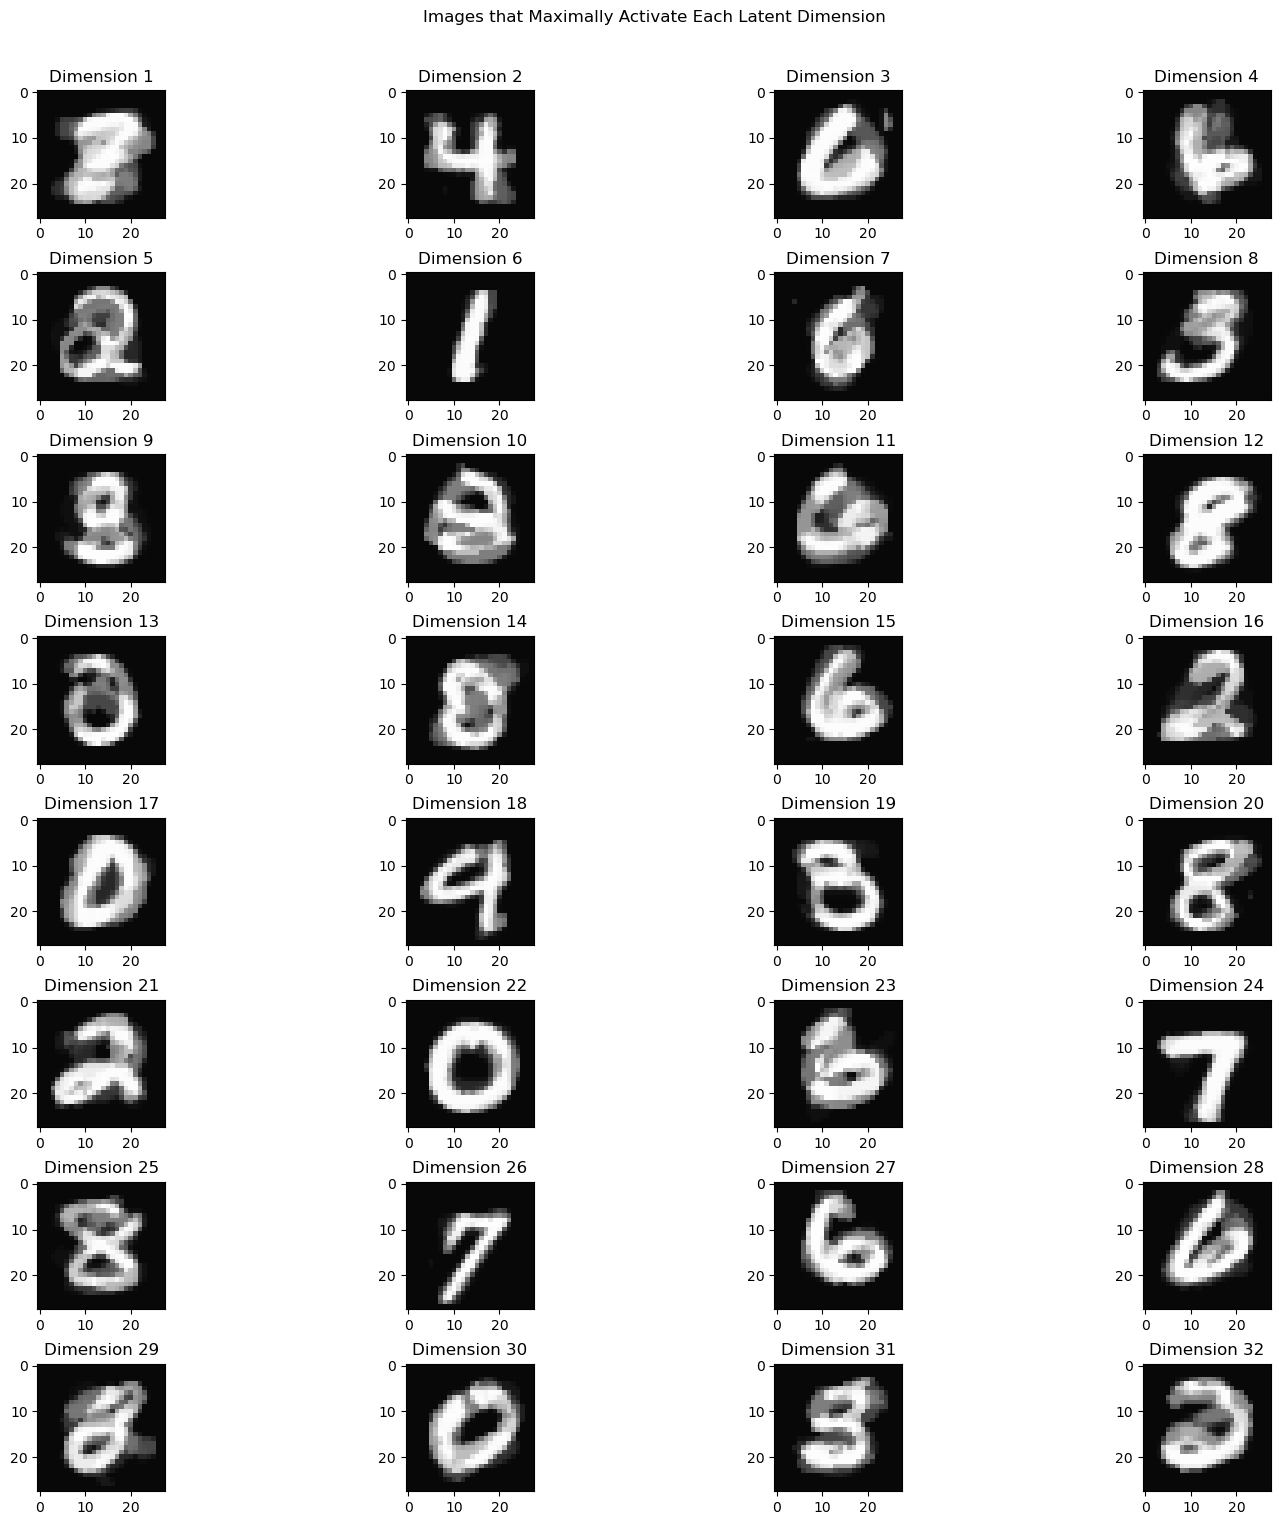

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━

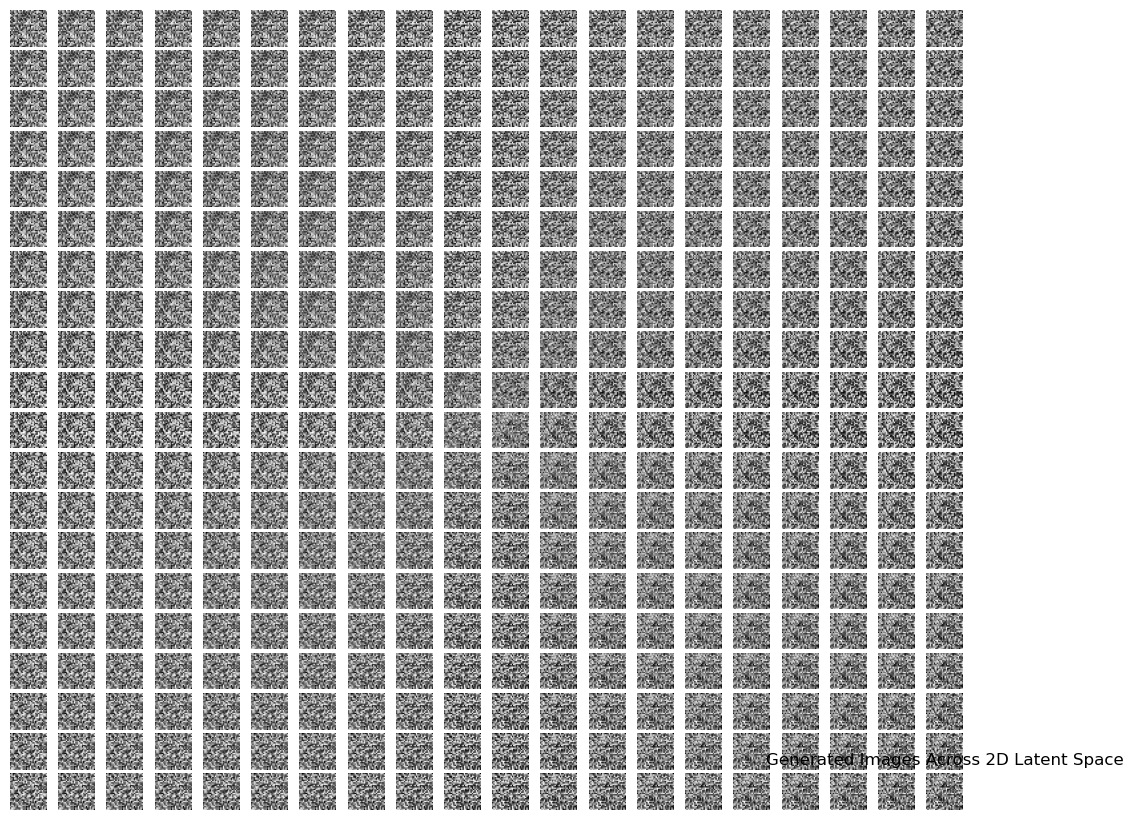

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape

# Load and prepare MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# We'll build a simple autoencoder first
input_img = Input(shape=(28, 28))
flat = Flatten()(input_img)

# Encoder - this creates our 32-dimensional latent space
encoded = Dense(32, activation='relu')(flat)

# Decoder
decoded = Dense(784, activation='sigmoid')(encoded)
decoded_img = Reshape((28, 28))(decoded)

# Full autoencoder model
autoencoder = Model(input_img, decoded_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Also create a separate encoder model to extract the latent space
encoder = Model(input_img, encoded)

# Train the model (commenting out for brevity - uncomment to train)
autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# Now, let's visualize the latent space
def visualize_latent_space():
    # Get the encoded representations
    encoded_imgs = encoder.predict(x_test)
    
    # 1. Basic visualization - histograms of each latent dimension
    plt.figure(figsize=(20, 4))
    for i in range(10):  # Show first 10 dimensions
        plt.subplot(2, 5, i+1)
        plt.hist(encoded_imgs[:, i], bins=50)
        plt.title(f'Dimension {i+1}')
    plt.tight_layout()
    plt.suptitle('Distribution of Latent Space Dimensions')
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # 2. Activation patterns by digit class
    plt.figure(figsize=(12, 8))
    for digit in range(10):
        # Get indices of test samples for this digit
        indices = np.where(y_test == digit)[0]
        # Get mean activation for this digit across all latent dimensions
        mean_activation = encoded_imgs[indices].mean(axis=0)
        plt.plot(mean_activation, label=f'Digit {digit}')
    
    plt.xlabel('Latent Dimension')
    plt.ylabel('Mean Activation')
    plt.legend()
    plt.title('Mean Latent Space Activation Pattern by Digit')
    plt.grid(True)
    plt.show()
    
    # 3. 2D visualization with dimensionality reduction
    from sklearn.manifold import TSNE
    
    # Use t-SNE to reduce 32 dimensions to 2 for visualization
    tsne = TSNE(n_components=2, random_state=42)
    encoded_imgs_2d = tsne.fit_transform(encoded_imgs)
    
    # Create scatter plot colored by digit class
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(encoded_imgs_2d[:, 0], encoded_imgs_2d[:, 1], 
                 c=y_test, alpha=0.6, cmap='viridis')
    plt.colorbar(scatter, label='Digit Class')
    plt.title('t-SNE Visualization of 32-D Latent Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
    
    # 4. Visualize what each neuron is detecting
    # Create a grid of images showing what activates each latent dimension
    n_latent = 32  # Number of latent dimensions
    plt.figure(figsize=(16, 16))
    
    # For each latent dimension
    for i in range(n_latent):
        # Find the 10 test images that maximize this dimension
        sorted_indices = np.argsort(encoded_imgs[:, i])[::-1]
        top_indices = sorted_indices[:10]
        
        # Create a subplot for this dimension
        plt.subplot(8, 4, i+1)
        plt.title(f'Dimension {i+1}')
        
        # Display a stack of the top 5 activating images
        for j, idx in enumerate(top_indices[:5]):
            # Add the image with some offset for visualization
            plt.imshow(x_test[idx], cmap='gray', alpha=0.5)
            
    plt.tight_layout()
    plt.suptitle('Images that Maximally Activate Each Latent Dimension', y=0.95)
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # 5. Interactive latent space exploration (using a 2D latent space)
    # First, define a 2D autoencoder
    input_img_2d = Input(shape=(28, 28))
    flat_2d = Flatten()(input_img_2d)
    encoded_2d = Dense(2, activation='relu')(flat_2d)  # Just 2 dimensions
    decoded_2d = Dense(784, activation='sigmoid')(encoded_2d)
    decoded_img_2d = Reshape((28, 28))(decoded_2d)
    
    autoencoder_2d = Model(input_img_2d, decoded_img_2d)
    autoencoder_2d.compile(optimizer='adam', loss='binary_crossentropy')
    
    # Create encoder and decoder models
    encoder_2d = Model(input_img_2d, encoded_2d)
    
    # Create a decoder model that takes a point in latent space as input
    latent_input = Input(shape=(2,))
    decoder_layers = autoencoder_2d.layers[-2:] # Get the decoder layers
    decoder_output = decoder_layers[1](decoder_layers[0](latent_input))
    decoder_2d = Model(latent_input, decoder_output)
    
    # Train the 2D autoencoder (uncomment to train)
    # autoencoder_2d.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test, x_test))
    
    # Get the encoded data
    encoded_imgs_real_2d = encoder_2d.predict(x_test)
    
    # Create a grid in latent space and see what the decoder generates
    n = 20  # Grid size
    grid_size = 15  # Range of the grid
    
    figure = plt.figure(figsize=(12, 10))
    
    # Create a grid of points in 2D latent space
    grid_x = np.linspace(-grid_size, grid_size, n)
    grid_y = np.linspace(-grid_size, grid_size, n)
    
    # Plot the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder_2d.predict(z_sample)
            digit = x_decoded[0].reshape(28, 28)
            
            ax = plt.subplot(n, n, i * n + j + 1)
            plt.imshow(digit, cmap='gray')
            plt.axis('off')
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)
    plt.title('Generated Images Across 2D Latent Space')
    plt.show()

# Call the visualization function after training your model
visualize_latent_space()